# 0. 데이터 다운로드

In [1]:
import torch # 파이토치 기본 라이브러리

# torchvision : 데이터셋, 모델 아키텍처, 컴퓨터 비전의 이미지 변환 기능 제공
import torchvision
from torchvision import datasets # torchvision에서 제공하는 데이터셋
from torchvision import transforms # 이미지 변환기능을 제공하는 패키지

# torch.utils.data : 파이토치 데이터 로딩 유틸리티
from torch.utils.data import DataLoader # 모델 훈련에 사용할 수 있는 미니 배치 구성하고
                                        # 매 epoch마다 데이터를 샘플링, 병렬처리 등의 일을 해주는 함수

from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jjlee1215","key":"64b9a90a1e4955d855fa8e59ea3a045f"}'}

In [4]:
# permmision warning 방지
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download
!kaggle datasets download -d ammaralfaifi/5class-weather-status-image-classification
# unzip(압축풀기)
!unzip -q 5class-weather-status-image-classification.zip -d weather/

100% 496M/498M [00:15<00:00, 35.8MB/s]
100% 498M/498M [00:15<00:00, 32.9MB/s]


In [5]:
data_dir = './weather/data/'

# 1. 데이터 전처리

In [6]:
# 나만의 데이터셋 + 변환기
# 각 폴더 안에 이미지 파일 확장자가 여러개 => 하려면 모든 파일 불러오면됨

from torch.utils.data import Dataset
import glob
import cv2
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = glob.glob(root_dir + '*/*')
        # print(root_dir + '*.*', self.image_paths)
        # print(len(self.image_paths))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        # print(image_filepath.split('/')[-2])
        # image
        image = Image.open(image_filepath).convert('RGB')

        transformed_image= self.transform(image)

        # label
        label_dict = {'cloudy': 0, 'foggy': 1, 'rainy': 2, 'snowy': 3, 'sunny': 4 }
        label = image_filepath.split('/')[-2]
        
        return transformed_image, label_dict[label]

In [7]:
transform = transforms.Compose([transforms.Resize([256, 256]), # resize 224 vs 256 확인하기
                                transforms.ToTensor()])

In [8]:
dataset_custom = MyDataset(root_dir=data_dir, transform=transform)

In [9]:
dataset_auto = datasets.ImageFolder(data_dir, transform=transform)

In [10]:
print('custom', len(dataset_custom))
print('auto', len(dataset_auto))

custom 18039
auto 18038


In [11]:
# dataset을 train, valid, test로 나누는 함수

def train_test_valid(dataset, valid_ratio, test_ratio):
    cloudy_list = []
    foggy_list = []
    rainy_list = []
    snowy_list = []
    sunny_list = []

    train_index = []
    valid_index = []
    test_index = []

    for i in range(len(dataset)):
        label = dataset[i][1]
        if label == 0:
            cloudy_list.append(i)
        elif label == 1:
            foggy_list.append(i)
        elif label == 2:
            rainy_list.append(i)
        elif label == 3:
            snowy_list.append(i)
        elif label == 4:
            sunny_list.append(i)

    for cnt, weather_index in enumerate((cloudy_list, foggy_list, rainy_list, snowy_list, sunny_list)):
        train_num = round(round(len(weather_index)*(1.0 - test_ratio)) * (1.0 - valid_ratio))
        valid_num = round(round(len(weather_index)*(1.0 - test_ratio)) * valid_ratio)
        test_num = round(len(weather_index)*test_ratio)

        # print(cnt, len(weather_index), train_num, valid_num, test_num)

        train_index += weather_index[:train_num]
        valid_index += weather_index[train_num: train_num+valid_num]
        test_index += weather_index[train_num+valid_num: train_num+valid_num+test_num]
        
    return train_index, valid_index, test_index

In [12]:
train_index, valid_index, test_index = train_test_valid(dataset_custom, valid_ratio=0.2, test_ratio=0.2)

print(len(train_index), len(valid_index), len(test_index))

trainset = Subset(dataset_custom, train_index)
validset = Subset(dataset_custom, valid_index)
testset = Subset(dataset_custom, test_index)

11546 2886 3607


In [13]:
trainset[0][0].size(), trainset[0][1]

(torch.Size([3, 256, 256]), 0)

In [14]:
class_train = []
class_valid = []
class_test = []

for i in range(5):
    train_weather = 0
    valid_weather = 0
    test_weather = 0

    for j in range(len(trainset)):
        if j < len(validset):
            if validset[j][1] == i:
                valid_weather += 1
        if j < len(testset):
            if testset[j][1] == i:
                test_weather += 1
        if trainset[j][1] == i:
            train_weather += 1

    class_train.append(train_weather)
    class_valid.append(valid_weather)
    class_test.append(test_weather)

print('train 속 weather 갯수 : ', class_train)
print('valid 속 weather 갯수 : ', class_valid)
print('test 속 weather 갯수  : ', class_test)

train 속 weather 갯수 :  [4290, 807, 1234, 1200, 4015]
valid 속 weather 갯수 :  [1072, 202, 308, 300, 1004]
test 속 weather 갯수  :  [1340, 252, 385, 375, 1255]


# 2. 시각화

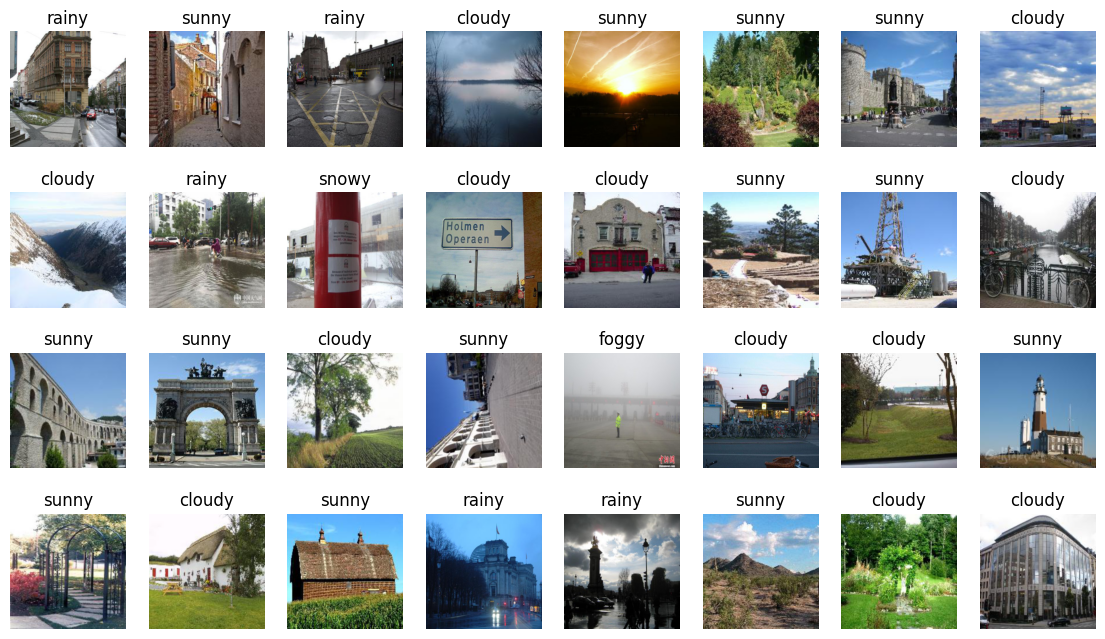

In [15]:
labels_map = {0 : 'cloudy', 1 : 'foggy', 2 : 'rainy', 3 : 'snowy', 4: 'sunny'}  # for cat and dog

figure, axes = plt.subplots(nrows=4, ncols=8, figsize=(14, 8))
axes = axes.flatten()

for i in range(32):
  rand_i = np.random.randint(0, len(trainset))
  image, label= trainset[rand_i][0].permute(1, 2, 0), trainset[rand_i][1]
  axes[i].axis('off')
  axes[i].imshow(image)
  axes[i].set_title(labels_map[label])

# 3. 배치

In [16]:
batch_size= 16
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [17]:
# custom의 경우
11546 / 16,  2886 / 16, 3607 / 16

(721.625, 180.375, 225.4375)

In [18]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 722
<class 'torch.utils.data.dataloader.DataLoader'> 181
<class 'torch.utils.data.dataloader.DataLoader'> 226


In [19]:
train_iter = iter(trainloader)
images, labels = next(train_iter)
images.size(), labels.size()

(torch.Size([16, 3, 256, 256]), torch.Size([16]))

# 4. 모델 설정

In [20]:
import torch.nn as nn # 파이토치에서 제공하는 다양한 계층 (Linear Layer, ....)
import torch.optim as optim # 옵티마이저 (경사하강법...)
import torch.nn.functional as F # 파이토치에서 제공하는 함수(활성화 함수...)

In [21]:
import torchvision.models as models

# https://github.com/pytorch/vision/tree/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models

model = models.vgg16_bn(weights=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:13<00:00, 40.9MB/s]


In [22]:
for parameter in model.parameters():
  print(parameter.requires_grad)
# parameter들의 requires_grad 속성이 True라는 것은 
# 오차 역전파를 통해 gradient를 전달할 수 있는 상태(즉, 학습이 가능한 상태태) 

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [23]:
for parameter in model.parameters():
  parameter.requires_grad = False # 학습이 안되게 고정

for parameter in model.classifier.parameters():
  parameter.requires_grad = True # 학습이 가능한 상태

In [24]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [25]:
model.classifier[3] = nn.Linear(in_features=4096, out_features=512, bias=True)
model.classifier[6] = nn.Linear(in_features=512, out_features=5, bias=True)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=512, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=512, out_features=5, bias=True)
)

In [26]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [27]:
out = model(images.to(device))
out.shape

torch.Size([16, 5])

In [28]:
for name, parameter in model.named_parameters():
  print(name, parameter.size())

features.0.weight torch.Size([64, 3, 3, 3])
features.0.bias torch.Size([64])
features.1.weight torch.Size([64])
features.1.bias torch.Size([64])
features.3.weight torch.Size([64, 64, 3, 3])
features.3.bias torch.Size([64])
features.4.weight torch.Size([64])
features.4.bias torch.Size([64])
features.7.weight torch.Size([128, 64, 3, 3])
features.7.bias torch.Size([128])
features.8.weight torch.Size([128])
features.8.bias torch.Size([128])
features.10.weight torch.Size([128, 128, 3, 3])
features.10.bias torch.Size([128])
features.11.weight torch.Size([128])
features.11.bias torch.Size([128])
features.14.weight torch.Size([256, 128, 3, 3])
features.14.bias torch.Size([256])
features.15.weight torch.Size([256])
features.15.bias torch.Size([256])
features.17.weight torch.Size([256, 256, 3, 3])
features.17.bias torch.Size([256])
features.18.weight torch.Size([256])
features.18.bias torch.Size([256])
features.20.weight torch.Size([256, 256, 3, 3])
features.20.bias torch.Size([256])
features.21

## 모델 컴파일 (손실함수, 옵티마이져 선택)

In [29]:
learning_rate = 0.0001
# 손실함수
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저(최적화함수, 예:경사하강법)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 규제의 강도 설정 weight_decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

# Learning Rate Schedule
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

# 모니터링하고 있는 값(예:valid_loss)의 최소값(min) 또는 최대값(max) patience 기간동안 줄어들지 않을 때(OnPlateau) lr에 factor(0.1)를 곱해주는 전략
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

In [30]:
from torchsummary import summary

In [31]:
summary(model, (3, 256, 256))  # 모델 사이즈 확인

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,

# 5. 모델 훈련

In [32]:
def validate(model, validloader, loss_fn):
  total = 0   
  correct = 0
  valid_loss = 0
  valid_accuracy = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음음
  with torch.no_grad():
    for images, labels in validloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)      
      # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력 데이터 준비
      # not Flatten !!
      # images.resize_(images.size()[0], 784)

      # 2. 전방향(Forward) 예측
      logit = model(images) # 예측 점수
      _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
      # preds = logit.max(dim=1)[1] 
      correct += int((preds == labels).sum()) # 배치 중 맞은 것의 개수가 correct에 누적
      total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

      loss = loss_fn(logit, labels)
      valid_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

    valid_accuracy = correct / total
  
  return valid_loss, valid_accuracy

In [33]:
writer = SummaryWriter()

def train_loop(model, trainloader, loss_fn, epochs, optimizer):  
  steps = 0
  steps_per_epoch = len(trainloader) 
  min_loss = 1000000
  max_accuracy = 0
  trigger = 0
  patience = 7 

  for epoch in range(epochs):
    model.train() # 훈련 모드
    train_loss = 0
    for images, labels in trainloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
      steps += 1
      # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력 데이터 준비
      # not Flatten !!
      # images.resize_(images.shape[0], 784) 

      # 2. 전방향(forward) 예측
      predict = model(images) # 예측 점수
      loss = loss_fn(predict, labels) # 예측 점수와 정답을 CrossEntropyLoss에 넣어 Loss값 반환

      # 3. 역방향(backward) 오차(Gradient) 전파
      optimizer.zero_grad() # Gradient가 누적되지 않게 하기 위해
      loss.backward() # 모델파리미터들의 Gradient 전파

      # 4. 경사 하강법으로 모델 파라미터 업데이트
      optimizer.step() # W <- W -lr*Gradient

      train_loss += loss.item()
      if (steps % steps_per_epoch) == 0 : 
        model.eval() # 평가 모드 : 평가에서 사용하지 않을 계층(배치 정규화, 드롭아웃)들을 수행하지 않게 하기 위해서
        valid_loss, valid_accuracy = validate(model, validloader, loss_fn)

        # tensorboard 시각화를 위한 로그 이벤트 등록
        writer.add_scalar('Train Loss', train_loss/len(trainloader), epoch+1)
        writer.add_scalar('Valid Loss', valid_loss/len(validloader), epoch+1)
        writer.add_scalars('Train Loss and Valid Loss',
                          {'Train' : train_loss/len(trainloader),
                            'Valid' : valid_loss/len(validloader)}, epoch+1)
        writer.add_scalar('Valid Accuracy', valid_accuracy, epoch+1)
        # -------------------------------------------

        print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
              'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
              'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
              'Valid Accuracy : {:.3f}'.format(valid_accuracy)            
              )
        
        # Best model 저장    
        # option 1 : valid_loss 모니터링
        # if valid_loss < min_loss: # 바로 이전 epoch의 loss보다 작으면 저장하기
        #   min_loss = valid_loss
        #   best_model_state = deepcopy(model.state_dict())          
        #   torch.save(best_model_state, 'best_checkpoint.pth')     
        
        # option 2 : valid_accuracy 모니터링      
        if valid_accuracy > max_accuracy : # 바로 이전 epoch의 accuracy보다 크면 저장하기
          max_accuracy = valid_accuracy
          best_model_state = deepcopy(model.state_dict())          
          torch.save(best_model_state, 'best_checkpoint.pth')  
        # -------------------------------------------

        # Early Stopping (조기 종료)
        if valid_loss > min_loss: # valid_loss가 min_loss를 갱신하지 못하면
          trigger += 1
          print('trigger : ', trigger)
          if trigger > patience:
            print('Early Stopping !!!')
            print('Training loop is finished !!')
            writer.flush()   
            return
        else:
          trigger = 0
          min_loss = valid_loss
        # -------------------------------------------

        # Learning Rate Scheduler
        scheduler.step(valid_loss)
        # -------------------------------------------
        
  writer.flush()
  return  

In [34]:
epochs = 55
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)
writer.close()

Epoch : 1/55....... Train Loss : 0.792 Valid Loss : 0.516 Valid Accuracy : 0.800
Epoch : 2/55....... Train Loss : 0.490 Valid Loss : 0.495 Valid Accuracy : 0.808
Epoch : 3/55....... Train Loss : 0.371 Valid Loss : 0.481 Valid Accuracy : 0.817
Epoch : 4/55....... Train Loss : 0.278 Valid Loss : 0.533 Valid Accuracy : 0.805
trigger :  1
Epoch : 5/55....... Train Loss : 0.224 Valid Loss : 0.585 Valid Accuracy : 0.808
trigger :  2
Epoch : 6/55....... Train Loss : 0.171 Valid Loss : 0.633 Valid Accuracy : 0.808
trigger :  3
Epoch : 7/55....... Train Loss : 0.138 Valid Loss : 0.657 Valid Accuracy : 0.810
trigger :  4
Epoch : 8/55....... Train Loss : 0.124 Valid Loss : 0.677 Valid Accuracy : 0.818
trigger :  5
Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch : 9/55....... Train Loss : 0.060 Valid Loss : 0.672 Valid Accuracy : 0.821
trigger :  6
Epoch : 10/55....... Train Loss : 0.040 Valid Loss : 0.693 Valid Accuracy : 0.822
trigger :  7
Epoch : 11/55....... Train Loss : 0.

# 모델 예측

In [35]:
# testloader에서 미니 배치 가져오기
test_iter = iter(testloader)
images, labels = next(test_iter)
images, labels = images.to(device), labels.to(device)
print(images.size(), labels.size())

# random한 index로 이미지 한장 준비하기
rnd_idx = 10
print(images[rnd_idx].shape, labels[rnd_idx])

torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([3, 256, 256]) tensor(0, device='cuda:0')


In [36]:
images[rnd_idx].shape

torch.Size([3, 256, 256])

In [37]:
# not Flatten!
# flattend_img = images[rnd_idx].view(1, 784)

# 준비된 이미지로 예측하기
model.eval()
with torch.no_grad():
  logit = model(images[rnd_idx].unsqueeze(0)) # model.forward()에서는 배치가 적용된 4차원 입력 기대

pred = logit.max(dim=1)[1]
print(pred == labels[rnd_idx]) # True : 잘 예측

tensor([True], device='cuda:0')


pred: tensor([0], device='cuda:0') labels: tensor(0, device='cuda:0')
cloudy cloudy


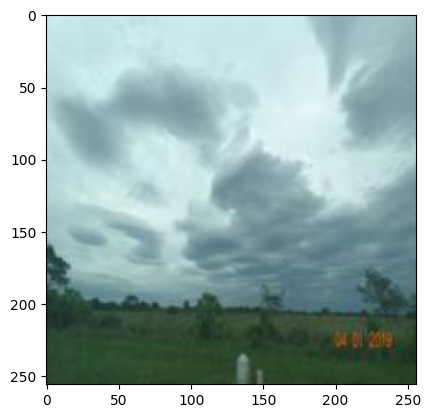

In [38]:
print("pred:", pred, "labels:", labels[rnd_idx])
print(labels_map[pred.cpu().item()], labels_map[labels[rnd_idx].cpu().item()])
plt.imshow(images[rnd_idx].permute(1, 2, 0).cpu())

# 모델 평가

In [39]:
def evaluation(model, testloader, loss_fn):
  total = 0   
  correct = 0
  test_loss = 0
  test_accuracy = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음음
  with torch.no_grad():
    for images, labels in testloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력 데이터 준비
      # not Flatten
      # images.resize_(images.size()[0], 784)
      
      # 2. 전방향(Forward) 예측
      logit = model(images) # 예측 점수
      _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
      # preds = logit.max(dim=1)[1] 
      correct += int((preds == labels).sum()) # 배치치 중 맞은 것의 개수가 correct에 누적
      total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

      loss = loss_fn(logit, labels)
      test_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

    test_accuracy = correct / total
   
  print('Test Loss : {:.3f}'.format(test_loss/len(testloader)), 
        'Test Accuracy : {:.3f}'.format(test_accuracy))

model.eval()
evaluation(model, testloader, loss_fn) 

Test Loss : 0.622 Test Accuracy : 0.836


# 모델 저장

In [40]:
# 현재 모델에 저장되어 있는 모델 파라미터터
model.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.3.bias', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.7.bias', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.10.bias', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.17.bias', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 

In [41]:
torch.save(model.state_dict(), 'last_checkpoint.pth')

In [42]:
# 시간이 흐른뒤 다시 모델 가져오기
last_state_dict = torch.load('last_checkpoint.pth')

In [43]:
last_state_dict.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.3.bias', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.7.bias', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.10.bias', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.17.bias', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 